# **Facial Expression Recognition**

This code shows training two similar models on two different datasets of the same classes. The first dataset is CK+ dataset (https://www.kaggle.com/gauravsharma99/ck48-5-emotions). The other dataset is FER2013 dataset(https://www.kaggle.com/msambare/fer2013).
The datasets contain grayscale images divided into five classes as shown later.

In [ ]:
#pip install scikit-plot

In [ ]:
#importing needed libraries
import os
import cv2
import math
import numpy as np
from collections import OrderedDict
import scikitplot
import seaborn as sns
from matplotlib import pyplot 

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from keras import backend as K
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#for showing the progress of for loop
from tqdm import tqdm

In [ ]:
#connection to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# CK Dataset

In [ ]:
#counting the number of images in each class and storing them in list for graphing them
images_path = "/content/drive/My Drive/CKdataset/"
myList = dict()
total_images = 0
for dir_ in os.listdir(images_path):
    count = 0
    for f in os.listdir(images_path + dir_ + "/"):
        count += 1
    total_images += count
    myList[dir_] = count
    print(f"{dir_} has {count} number of images")
    
print(f"\ntotal images: {total_images}")

anger has 135 number of images
fear has 75 number of images
sadness has 84 number of images
surprise has 249 number of images
happy has 207 number of images

total images: 750


`sadness` and `fear` has very low number of images as compared to other classes

<BarContainer object of 5 artists>

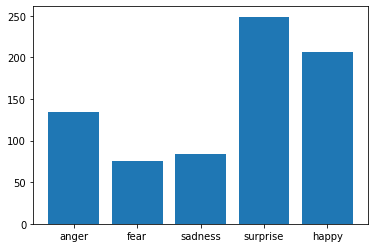

In [ ]:
#graphing number of images in each class
pyplot.bar(myList.keys(), myList.values())

In [ ]:
#getting names of classes for using them later.
labels= os.listdir(images_path)

In [ ]:
#reading images and storing their pixels in the first array, and their class label in the second array.
img_arr = np.empty(shape=(total_images, 48, 48, 1))
img_label = np.empty(shape=(total_images))
label_to_text = {}

idx = 0
label = 0
for dir_ in os.listdir(images_path):
    if dir_ in  labels:
        for f in tqdm(os.listdir( images_path+ dir_ + "/")):
            img_arr[idx] = np.expand_dims(cv2.imread(images_path + dir_ + "/" + f, 0), axis=2)
            img_label[idx] = label
            idx += 1
        label_to_text[label] = dir_
        label += 1

img_label = np_utils.to_categorical(img_label)

img_arr.shape, img_label.shape, label_to_text

100%|██████████| 207/207 [00:59<00:00,  3.47it/s]


((750, 48, 48, 1),
 (750, 5),
 {0: 'anger', 1: 'fear', 2: 'sadness', 3: 'surprise', 4: 'happy'})

In [ ]:
#splitting the dataset into 7:3 for training and testing
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label, train_size=0.7, stratify=img_label, shuffle=True, random_state=42)
X_train.shape, X_test.shape

((525, 48, 48, 1), (225, 48, 48, 1))

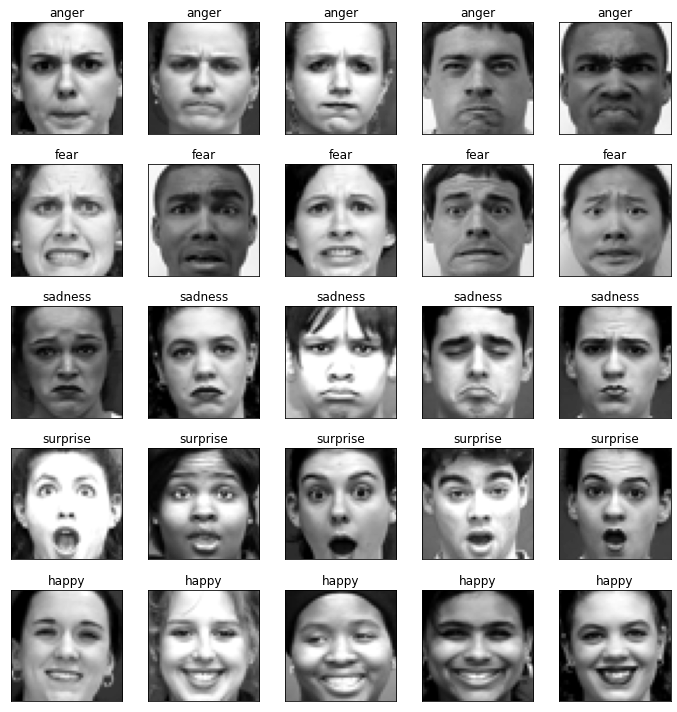

In [ ]:
#showing some samples of the dataset
fig = pyplot.figure(1, (10,10))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(y_train[:,k]==1)[0], size=5, replace=False)
    sample_images = X_train[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(5,5,idx)
        ax.imshow(img.reshape(48,48), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [ ]:
# data normalization
X_train = X_train / 255.
X_test = X_test / 255.

In [ ]:
#generating more images in the training set
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [ ]:
#defining a function for building CNN model. The model contains:
#input layer, 6 Conv layers, flatten layer, 1 hiddedn dense layer and the out put layer.
def build_dcnn(input_shape, num_classes):
    model_in = Input(shape=input_shape, name="input")
    
    conv2d_1 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1'
    )(model_in)
    batchnorm_1 = BatchNormalization(name='batchnorm_1')(conv2d_1)
    conv2d_2 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2'
    )(batchnorm_1)
    batchnorm_2 = BatchNormalization(name='batchnorm_2')(conv2d_2)
    
    maxpool2d_1 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_1')(batchnorm_2)
    dropout_1 = Dropout(0.3, name='dropout_1')(maxpool2d_1)

    conv2d_3 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3'
    )(dropout_1)
    batchnorm_3 = BatchNormalization(name='batchnorm_3')(conv2d_3)
    conv2d_4 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4'
    )(batchnorm_3)
    batchnorm_4 = BatchNormalization(name='batchnorm_4')(conv2d_4)
    
    maxpool2d_2 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2')(batchnorm_4)
    dropout_2 = Dropout(0.3, name='dropout_2')(maxpool2d_2)

    conv2d_5 = Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5'
    )(dropout_2)
    batchnorm_5 = BatchNormalization(name='batchnorm_5')(conv2d_5)
    conv2d_6 = Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6'
    )(batchnorm_5)
    batchnorm_6 = BatchNormalization(name='batchnorm_6')(conv2d_6)
    
    maxpool2d_3 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3')(batchnorm_6)
    dropout_3 = Dropout(0.3, name='dropout_3')(maxpool2d_3)

    flatten = Flatten(name='flatten')(dropout_3)
    
    dense_1 = Dense(
        128,
        activation='relu',
        kernel_initializer='he_normal',
        name='dense1'
    )(flatten)
    batchnorm_7 = BatchNormalization(name='batchnorm_7')(dense_1)
    dropout_4 = Dropout(0.4, name='dropout_4')(batchnorm_7)

    model_out = Dense(
        num_classes,
        activation='softmax',
        name='out_layer'
    )(dropout_4)

    model = Model(inputs=model_in, outputs=model_out, name="DCNN")
    
    return model

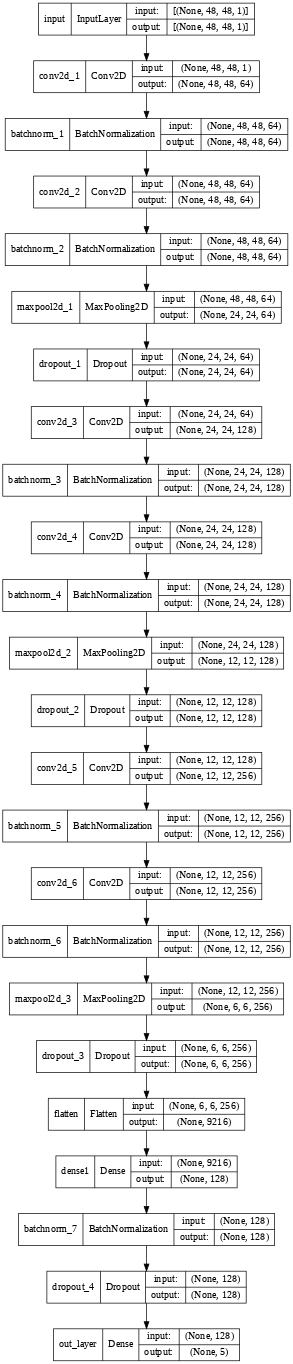

In [ ]:
#compiling and plotting the model.
INPUT_SHAPE = (48, 48, 1)
optim = optimizers.Adam(0.001)

model = build_dcnn(input_shape=(48,48,1), num_classes=len(label_to_text))
model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
)

plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='model.png')

In [ ]:
#prepraing the earcly stopping and number of epochs for training the model.
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00008,
    patience=12,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.4,
    patience=6,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

batch_size = 10
epochs = 60

In [ ]:
#training the first model on the dataset.
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/60
52/52 [==============================] - 31s 571ms/step - loss: 1.9841 - accuracy: 0.3524 - val_loss: 6.5792 - val_accuracy: 0.3733 - lr: 0.0010
Epoch 2/60
52/52 [==============================] - 30s 567ms/step - loss: 1.3338 - accuracy: 0.5238 - val_loss: 3.0295 - val_accuracy: 0.3244 - lr: 0.0010
Epoch 3/60
52/52 [==============================] - 30s 569ms/step - loss: 1.2527 - accuracy: 0.5600 - val_loss: 1.2402 - val_accuracy: 0.5778 - lr: 0.0010
Epoch 4/60
52/52 [==============================] - 30s 571ms/step - loss: 0.9812 - accuracy: 0.6381 - val_loss: 2.0636 - val_accuracy: 0.5511 - lr: 0.0010
Epoch 5/60
52/52 [==============================] - 30s 570ms/step - loss: 0.8749 - accuracy: 0.6952 - val_loss: 0.8667 - val_accuracy: 0.7600 - lr: 0.0010
Epoch 6/60
52/52 [==============================] - 30s 568ms/step - loss: 0.8619 - accuracy: 0.6933 - val_loss: 0.5894 - val_accuracy: 0.7689 - lr: 0.0010
Epoch 7/60
52/52 [==============================] - 30s 571ms/st

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

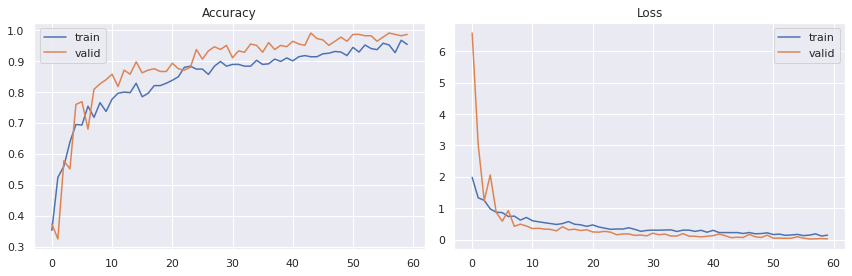

In [ ]:
#graphing the accuracy and loss for training and validating the model
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history.png')
pyplot.show()

In [ ]:
#showing the number that represents each class.
label_to_text

{0: 'anger', 1: 'fear', 2: 'sadness', 3: 'surprise', 4: 'happy'}

In [ ]:
#making a dictionary for each class and its correspending number.
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'anger': 0, 'fear': 1, 'happy': 4, 'sadness': 2, 'surprise': 3}

test accuracy: 98.6667 %


              precision    recall  f1-score   support

           0       1.00      0.97      0.99        40
           1       1.00      0.91      0.95        23
           2       0.96      1.00      0.98        25
           3       1.00      1.00      1.00        75
           4       0.97      1.00      0.98        62

    accuracy                           0.99       225
   macro avg       0.99      0.98      0.98       225
weighted avg       0.99      0.99      0.99       225



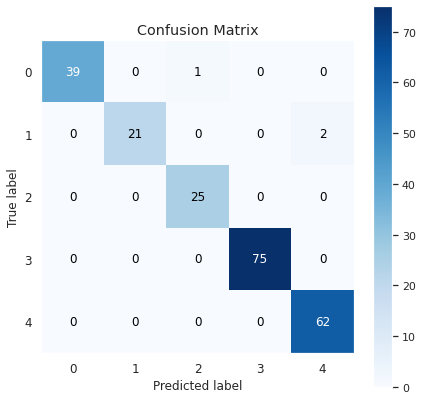

In [ ]:
#evaluating the model on the validation set and printing the results and confusion matrix.
yhat_test = model.predict(X_test)
yhat_test = np.argmax(yhat_test, axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig("confusion_matrix_model3pipes.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

# FER Dataset

In [ ]:
#counting the images in each class of the second dataset
images2_path = "/content/drive/My Drive/FERdataset/"
myList2 = dict()
total_images2 = 0
for dir_ in os.listdir(images2_path):
    count2 = 0
    for f in os.listdir(images2_path + dir_ + "/"):
        count2 += 1
    total_images2 += count2
    myList2[dir_] = count2
    print(f"{dir_} has {count2} number of images")
    
print(f"\ntotal images: {total_images2}")

fear has 1034 number of images
surprise has 831 number of images
sad has 1247 number of images
happy has 1784 number of images
angry has 958 number of images

total images: 5854


<BarContainer object of 5 artists>

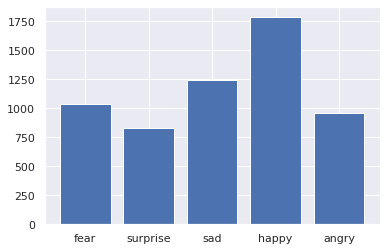

In [ ]:
#plotting the number of images in each class.
pyplot.bar(myList2.keys(), myList2.values())

In [ ]:
#getting names of classes to use them later.
labels2= os.listdir(images2_path)

In [ ]:
#reading images in each class and storing their pixels and their labels in arrays,
img_arr2 = np.empty(shape=(total_images2, 48, 48, 1))
img_label2 = np.empty(shape=(total_images2))
label_to_text2 = {}

idx2 = 0
label2 = 0
for dir_ in os.listdir(images2_path):
    if dir_ in  labels2:
        for f in tqdm(os.listdir( images2_path+ dir_ + "/")):
            img_arr2[idx2] = np.expand_dims(cv2.imread(images2_path + dir_ + "/" + f, 0), axis=2)
            img_label2[idx2] = label2
            idx2 += 1
        label_to_text2[label2] = dir_
        label2 += 1

img_label2 = np_utils.to_categorical(img_label2)

img_arr2.shape, img_label2.shape, label_to_text2

100%|██████████| 958/958 [04:55<00:00,  3.24it/s]


((5854, 48, 48, 1),
 (5854, 5),
 {0: 'fear', 1: 'surprise', 2: 'sad', 3: 'happy', 4: 'angry'})

In [ ]:
#splitting the dataset into 7:3 training and testing
X_train2, X_test2, y_train2, y_test2 = train_test_split(img_arr2, img_label2, train_size=0.7, stratify=img_label2, shuffle=True, random_state=42)
X_train2.shape, X_test2.shape

((4097, 48, 48, 1), (1757, 48, 48, 1))

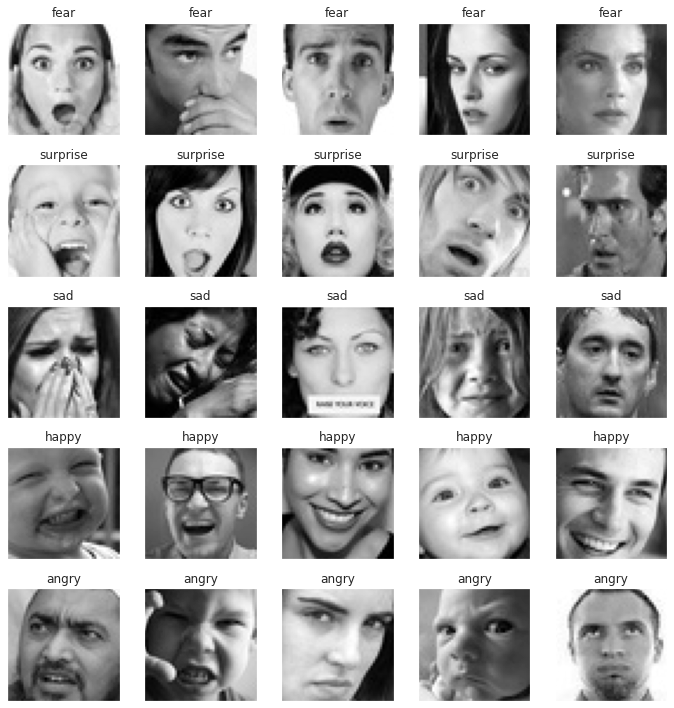

In [ ]:
#showing some samples of the dataset
fig = pyplot.figure(1, (10,10))

idx = 0
for k in label_to_text2:
    sample_indices = np.random.choice(np.where(y_train2[:,k]==1)[0], size=5, replace=False)
    sample_images = X_train2[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(5,5,idx)
        ax.imshow(img.reshape(48,48), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text2[k])
        pyplot.tight_layout()

In [ ]:
# data normalization
X_train2 = X_train2 / 255.
X_test2 = X_test2 / 255.

In [ ]:
#generating more images for training set.
train_datagen2 = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen2.fit(X_train2)

In [ ]:
#compiling model 2
INPUT_SHAPE = (48, 48, 1)
optim = optimizers.Adam(0.001)

model2 = build_dcnn(input_shape=(48,48,1), num_classes=len(label_to_text2))
model2.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
)

In [ ]:
#training model 2
history2 = model2.fit_generator(
    train_datagen2.flow(X_train2, y_train2, batch_size=batch_size),
    validation_data=(X_test2, y_test2),
    steps_per_epoch=len(X_train2) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/60
409/409 [==============================] - 230s 558ms/step - loss: 1.9232 - accuracy: 0.2577 - val_loss: 1.6927 - val_accuracy: 0.3244 - lr: 0.0010
Epoch 2/60
409/409 [==============================] - 228s 555ms/step - loss: 1.6915 - accuracy: 0.2885 - val_loss: 1.9914 - val_accuracy: 0.2920 - lr: 0.0010
Epoch 3/60
409/409 [==============================] - 228s 556ms/step - loss: 1.5971 - accuracy: 0.3144 - val_loss: 1.4126 - val_accuracy: 0.4058 - lr: 0.0010
Epoch 4/60
409/409 [==============================] - 229s 558ms/step - loss: 1.5023 - accuracy: 0.3615 - val_loss: 1.3716 - val_accuracy: 0.4337 - lr: 0.0010
Epoch 5/60
409/409 [==============================] - 227s 554ms/step - loss: 1.4349 - accuracy: 0.3837 - val_loss: 1.3044 - val_accuracy: 0.4730 - lr: 0.0010
Epoch 6/60
409/409 [==============================] - 228s 556ms/step - loss: 1.3754 - accuracy: 0.4254 - val_loss: 1.2640 - val_accuracy: 0.4678 - lr: 0.0010
Epoch 7/60
409/409 [==========================

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

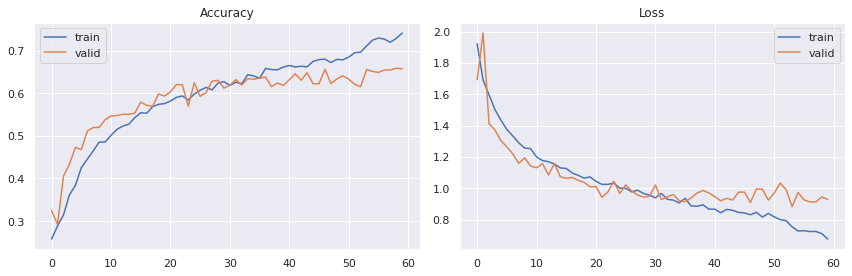

In [ ]:
#graphing the accuracy and loss for training and validation of model 2
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history2.epoch, history2.history['accuracy'], label='train')
sns.lineplot(history2.epoch, history2.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history2.epoch, history2.history['loss'], label='train')
sns.lineplot(history2.epoch, history2.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history2.png')
pyplot.show()

In [ ]:
#showing the number that represents each class.
label_to_text2

{0: 'fear', 1: 'surprise', 2: 'sad', 3: 'happy', 4: 'angry'}

In [ ]:
#making a dictionary for each class and its correspending number.
text_to_label2 = dict((v,k) for k,v in label_to_text2.items())
text_to_label2

{'angry': 4, 'fear': 0, 'happy': 3, 'sad': 2, 'surprise': 1}

test accuracy: 65.794 %


              precision    recall  f1-score   support

           0       0.51      0.36      0.42       310
           1       0.77      0.75      0.76       249
           2       0.54      0.61      0.57       374
           3       0.89      0.85      0.87       536
           4       0.49      0.60      0.54       288

    accuracy                           0.66      1757
   macro avg       0.64      0.63      0.63      1757
weighted avg       0.66      0.66      0.66      1757



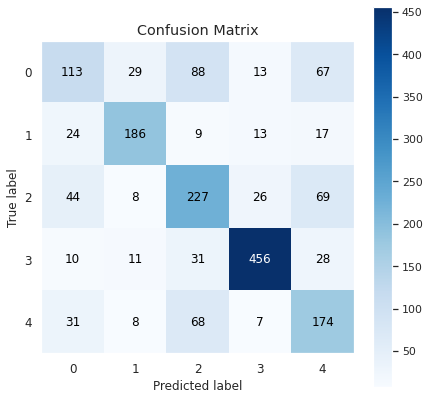

In [ ]:
#evalauting model 2 and showing results and confusion matrix
yhat_test2 = model2.predict(X_test2)
yhat_test2 = np.argmax(yhat_test2, axis=1)
ytest_2 = np.argmax(y_test2, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_2, yhat_test2, figsize=(7,7))
pyplot.savefig("confusion_matrix_model3pipes2.png")

test_accu2 = np.sum(ytest_2 == yhat_test2) / len(ytest_2) * 100
print(f"test accuracy: {round(test_accu2, 4)} %\n\n")

print(classification_report(ytest_2, yhat_test2))